# OTalign 200 cell lines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.decomposition import PCA
import scanpy as sc
import math

import pandas as pd

from matplotlib import animation, rc
from IPython.display import HTML

import sys
DATA_PATH = '/home/risitop/OneDrive/Documents/PHD/y1/data/'
sys.path.append(DATA_PATH)

In [77]:
import ot

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_discrepancy_nn(Xs, Xt, n_neighbors=3):
    nns = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xs).kneighbors_graph(Xs).toarray()
    nnt = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xt).kneighbors_graph(Xt).toarray()
    D = nnt - nns
    return np.linalg.norm(D, axis=0).astype(float)/n_neighbors

def cosine_pairwise_distance(X):        
    n = np.linalg.norm(X, axis=1)
    X = np.dot(np.diag(1/n), X)
    return cdist(X, X)

def compute_discrepancy_d(Xs, Xt):
    Ds = cosine_pairwise_distance(Xs)
    Dt = cosine_pairwise_distance(Xt)
    D = Ds - Dt
    return 1 / np.linalg.norm(D, axis=1)
    
def OT_raw(Xs, Yt, alph=1, bet=1):
    w_x, w_y = np.ones((len(Xs),))/len(Xs), np.ones((len(Yt),))/len(Yt)
    M = ot.dist(Xs, Yt)**alph
    M /= M.max()
    Gs = ot.sinkhorn(w_x, w_y, M, 1e-3)
    return np.dot(np.diag(1/w_x), np.dot(Gs, Yt))

def OT_regularized_nn(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = 1 - compute_discrepancy_nn(Xs, Xt, n_neighbors)
    return np.dot(np.diag(lambdas), Xt - Xs) + Xs

def OT_regularized_d(Xs, Yt, alph=1, bet=1):
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = 1 - compute_discrepancy_d(Xs, Xt)
    print(lambdas)
    return np.dot(np.diag(lambdas), Xt - Xs) + Xs

def OT_oob(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    n = len(Xs)
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = compute_discrepancy_nn(Xs, Xt, n_neighbors)
    return np.hstack((Xt, np.reshape(lambdas, (n, 1))))

In [62]:
plt.style.use('dark_background')

In [63]:
adata = sc.read_h5ad(DATA_PATH + 'sc200CL_pp.h5ad')
adata

AnnData object with n_obs × n_vars = 42362 × 30314
    obs: 'Cell_line', 'Pool_ID', 'Cancer_type', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [64]:
# JHU011
id_JHU011 = adata.obs['Cell_line'].str.decode('utf-8').str.contains('JHU011')
adata_JHU011 = adata[id_JHU011,:]
target_X = adata_JHU011.obs[ ['G1/S_score', 'G2/M_score'] ].values

/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


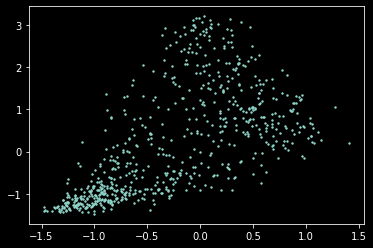

In [65]:
plt.scatter(target_X[:,0], target_X[:,1], s=2)

In [79]:
adata_cl = adata[adata.obs['Cell_line'].str.decode('utf-8').str.contains('2313287_STOMACH'),:]
source_X = adata_cl.obs[ ['G1/S_score', 'G2/M_score'] ].values
OT_regularized_d(source_X, target_X)

[0.58908821 0.65230845 0.61014879 0.49413626 0.64815986 0.53138435
 0.84341716 0.46827977 0.77271861 0.46689496 0.44958351 0.6843885
 0.59596711 0.54069009 0.45265618 0.48523147 0.5773186  0.70269399
 0.57031413 0.45674843 0.5580119  0.67673983 0.41190733 0.52621829
 0.46925626 0.64177542 0.48576919 0.46050585 0.48041328 0.48574783
 0.53209642 0.46816467 0.46340826 0.59184656 0.62254505 0.68930983
 0.47158101 0.61128885 0.46142684 0.57306529 0.64938587 0.45005785
 0.48566    0.47792815 0.49541307 0.73487366 0.7148527  0.46659792
 0.66156059 0.47318044 0.51516969 0.49518016 0.58968447 0.71104984
 0.73208315 0.53281692 0.65089736 0.47383697 0.55310199 0.68988568
 0.57706957 0.68126732 0.734053   0.50450972 0.40402121 0.47791326
 0.71916976 0.5186297  0.47612136 0.76071299 0.66246255 0.5988856
 0.43501403 0.58507481 0.51733626 0.67845104 0.44840309 0.60247952
 0.56762728 0.59064522 0.50481477 0.54027861 0.58560401 0.57269811
 0.58551437]


/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


array([[-0.08529216,  1.59192558],
       [-0.60090065, -0.16076064],
       [-0.55994994, -1.00538806],
       [ 0.76708181,  0.95417854],
       [ 0.72427195,  0.3885552 ],
       [ 0.62408788, -0.72411056],
       [ 0.14525813,  0.16607982],
       [-0.99901972, -1.15689726],
       [ 0.69828371, -0.02681313],
       [-1.1658576 , -1.29641225],
       [ 0.36534507,  1.76646277],
       [-0.30406576, -0.78220734],
       [-0.60444014, -1.04060783],
       [-0.33248821,  0.03968437],
       [ 0.30465922,  1.18335277],
       [-0.85892244, -1.37620754],
       [-0.20487864,  2.04561849],
       [ 0.48047948,  0.3711166 ],
       [ 0.27419785,  0.41439909],
       [-0.7248751 , -0.90047876],
       [ 0.50035294, -0.39210646],
       [ 0.4722924 ,  0.43287054],
       [-0.32852757,  0.3211946 ],
       [-1.32343495, -1.23255735],
       [-1.1763448 , -1.29156777],
       [-0.39721208, -0.18861533],
       [ 0.02075663,  2.11860119],
       [-0.51321411, -0.58395508],
       [ 0.54079389,

In [72]:
Xs_before = []
Xs_raw = []
Xs_regularized_nn = []
Xs_regularized_d = []
labels = []
for i, cl in enumerate(set(adata.obs['Cell_line'].str.decode('utf-8'))):
    adata_cl = adata[adata.obs['Cell_line'].str.decode('utf-8').str.contains(cl),:]
    source_X = adata_cl.obs[ ['G1/S_score', 'G2/M_score'] ].values
    if len(source_X) < 20:
        continue
    Xs_before.append(source_X)
    labels.append(cl)
    Xs_raw.append(OT_raw(source_X, target_X))
    Xs_regularized_nn.append(OT_regularized_nn(source_X, target_X, n_neighbors=5))
    Xs_regularized_d.append(OT_regularized_d(source_X, target_X))

/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be remo

/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be remo

/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be remo

/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be remo

/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be remo

/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be remo

/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be remo

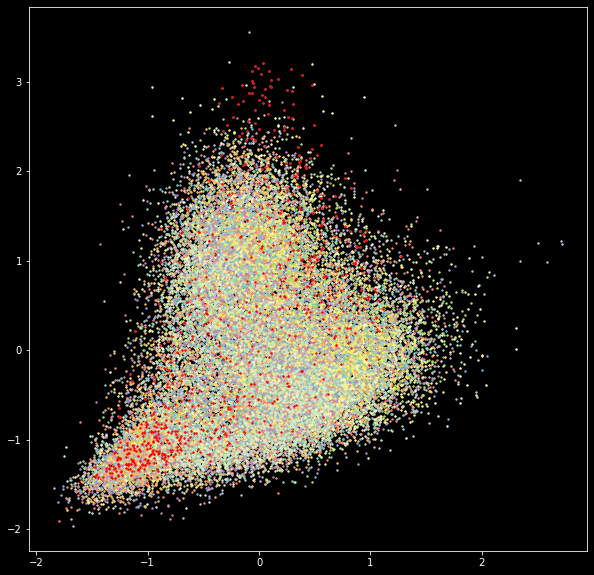

In [73]:
plt.figure(figsize=(10,10))

for l, X in zip(labels, Xs_before):
    plt.scatter(X[:,0], X[:,1], s=2, label=l)
plt.scatter(target_X[:,0], target_X[:,1], s=2, label='JHU011', c='red')
plt.savefig('200cl_before.png')

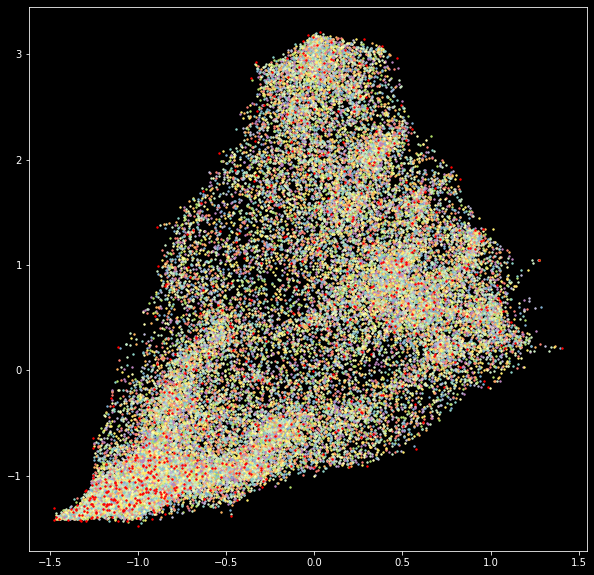

In [74]:
plt.figure(figsize=(10,10))

for l, X in zip(labels, Xs_raw):
    plt.scatter(X[:,0], X[:,1], s=2, label=l)
plt.scatter(target_X[:,0], target_X[:,1], s=2, label='JHU011', c='red')
plt.savefig('200cl_rawot.png')

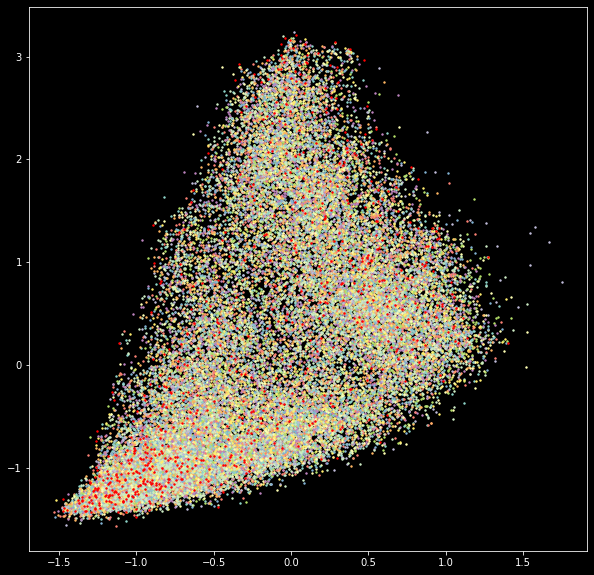

In [75]:
plt.figure(figsize=(10,10))

for l, X in zip(labels, Xs_regularized_nn):
    plt.scatter(X[:,0], X[:,1], s=2, label=l)
plt.scatter(target_X[:,0], target_X[:,1], s=2, label='JHU011', c='red')
plt.savefig('200cl_regot.png')

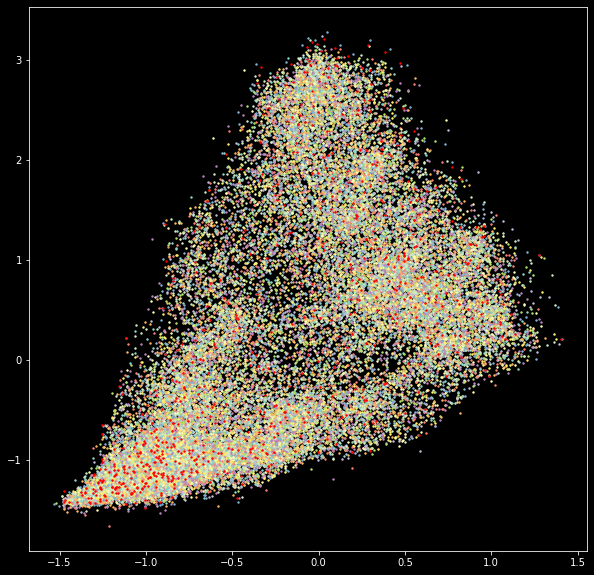

In [76]:
plt.figure(figsize=(10,10))

for l, X in zip(labels, Xs_regularized_d):
    plt.scatter(X[:,0], X[:,1], s=2, label=l)
plt.scatter(target_X[:,0], target_X[:,1], s=2, label='JHU011', c='red')
plt.savefig('200cl_regot.png')

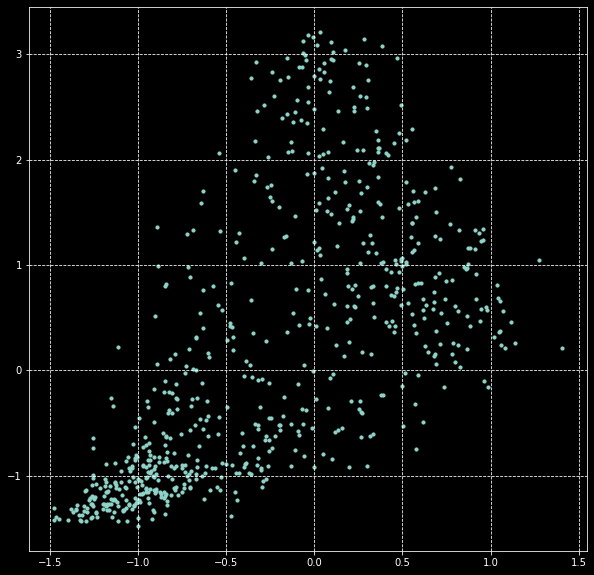

In [133]:
sig = 1 / (1 + np.exp(target_X)) - .5
cc = np.arctan2(sig[:,1], sig[:,0])
cc = (cc - cc.min()) / (cc.max() - cc.min())

In [150]:
conf = 1 - 1 / (1 + np.exp(np.linalg.norm(target_X, axis=1)))

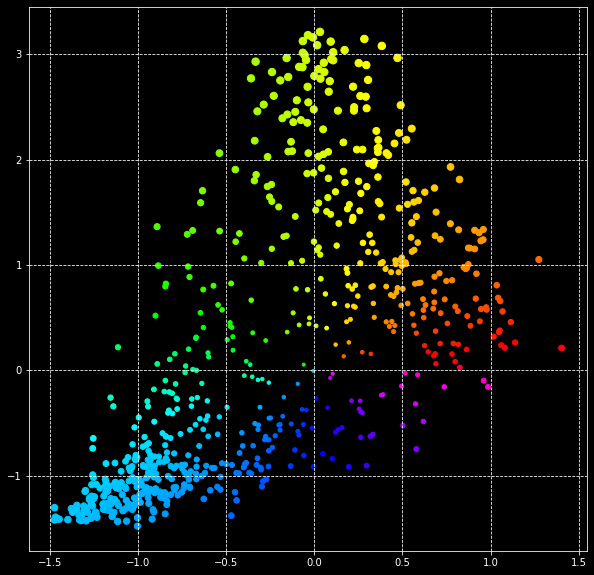

In [154]:
plt.figure(figsize=(10,10))

plt.scatter(target_X[:,0], target_X[:,1], c=cc, s=(4*conf)**3, cmap='gist_rainbow')
plt.grid(linestyle='--')

In [104]:
cc

array([0.55022949, 0.81570474, 0.96176779, 0.59425313, 0.81835269,
       0.63015699, 0.28224007, 0.16652982, 0.74656585, 0.57603229,
       0.79447347, 0.79683465, 0.42705879, 0.94257709, 0.59039509,
       0.77740114, 0.08134686, 0.25661479, 0.59988999, 0.81183159,
       0.25273125, 0.86315713, 0.78568578, 0.82418043, 0.65737307,
       0.3961055 , 0.72054491, 0.29075988, 0.69724483, 0.75691295,
       1.03036362, 0.86994276, 0.94246801, 0.86681014, 0.80019923,
       0.82469602, 0.76133818, 0.54224542, 1.03055683, 0.56250104,
       0.87062077, 0.60939109, 0.79736846, 0.78461908, 0.83149385,
       0.75721253, 0.5706231 , 0.15700234, 0.89058767, 0.74670037,
       0.70708684, 0.78885008, 0.64120332, 0.34728861, 0.90676394,
       0.83221224, 0.69378723, 0.78682743, 0.65296999, 0.94209153,
       0.68041945, 0.70520094, 0.68285536, 0.65742513, 0.71061003,
       0.8313525 , 0.78211808, 0.77997389, 0.44876989, 0.34346548,
       0.79661389, 0.8348157 , 0.75933101, 0.49980349, 0.20466